In [1]:
import pandas as pd

In [4]:
df = pd.read_csv(r"train.csv")

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df.shape

(404290, 6)

The dataset is too big so we will only use a sample from this dataset

In [7]:
try:
    data = df.sample(10000, random_state = 42)
    print("Done with making the sample")
except Exception as e:
    print(e)

Done with making the sample


In [8]:
df = data

In [9]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [11]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 57.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [12]:
import spacy

nlp = spacy.load('en_core_web_md')

In [13]:
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc if
        not token.is_stop and not token.is_punct
    ]
    return " ".join(tokens)

In [14]:
df["clean_q1"] = df["question1"].apply(preprocess)
df["clean_q2"] = df["question2"].apply(preprocess)

In [15]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,clean_q1,clean_q2
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,play pokémon korea,play pokémon china
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,good dish crab cake,good dish buffalo chicken
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,advisable well material crash test automobile ...,good server setup buddypress
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,improve logical programming skill,improve logical skill programming
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,close 3rd world war,close world war iii


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
tfidf = TfidfVectorizer()
all_ques = pd.concat([df["clean_q1"], df["clean_q2"]])
tfidf.fit_transform(all_ques)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 97051 stored elements and shape (20000, 11954)>

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
similarity_matrix = cosine_similarity(tfidf.transform(df["clean_q1"]), tfidf.transform(df["clean_q2"]))

df["sim"] = [similarity_matrix[i, i] for i in range(len(df))]

In [20]:
df["sim"] = (df.sim >= .75).astype('int64')

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
print(classification_report(df["is_duplicate"], df["sim"]))

              precision    recall  f1-score   support

           0       0.71      0.78      0.75      6265
           1       0.56      0.47      0.51      3735

    accuracy                           0.67     10000
   macro avg       0.64      0.63      0.63     10000
weighted avg       0.66      0.67      0.66     10000



In [25]:
conf_matrix = confusion_matrix(df["is_duplicate"], df["sim"])
print(conf_matrix)

[[4890 1375]
 [1969 1766]]


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

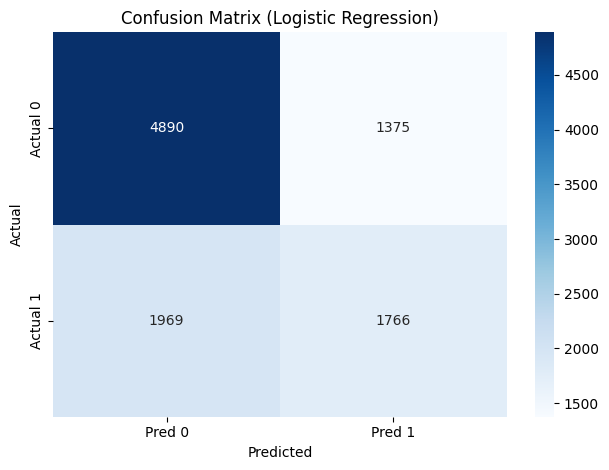

In [28]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix (Logistic Regression)", fontsize=12)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()